# Pre-Reqs:

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import zscore
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from scipy.stats import zscore
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures

In [2]:
#Creating Dataframes
TrainDataset = pd.read_csv('/content/train.csv')
TestDataset = pd.read_csv('/content/test.csv')

In [3]:
TrainDataset.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [4]:
#Commented out - saves space aha!
#print(TrainDataset.head())
print('\n')
#print("Train Dataset shape -", TrainDataset.shape)
print('\n')
#print(TestDataset.head())
print('\n')
#print("Test Dataset shape -",TestDataset.shape)

# Data-Cleanup:

In [ ]:
#Check for empty columns in datasets
#print("Train Dataset:\n",TrainDataset.isnull().sum())
#print(" ")
#print("Test Dataset:\n",TestDataset.isnull().sum())

#No null inputs

# Data Analysis:

**TrainDataset:**

In [17]:
TrainDfRCount1 = TrainDataset['rainfall'].value_counts().get(1)
print("Count of 1:")
print(TrainDfRCount1)
print("\n")
TrainDfRCount0 = TrainDataset['rainfall'].value_counts().get(0)
print("Count of 0:")
print(TrainDfRCount0)

Count of 1:
1650


Count of 0:
540


<ipython-input-5-454befc45a2f>:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(BoxPlotDf.values, labels=BoxPlotDf.columns, patch_artist=True)


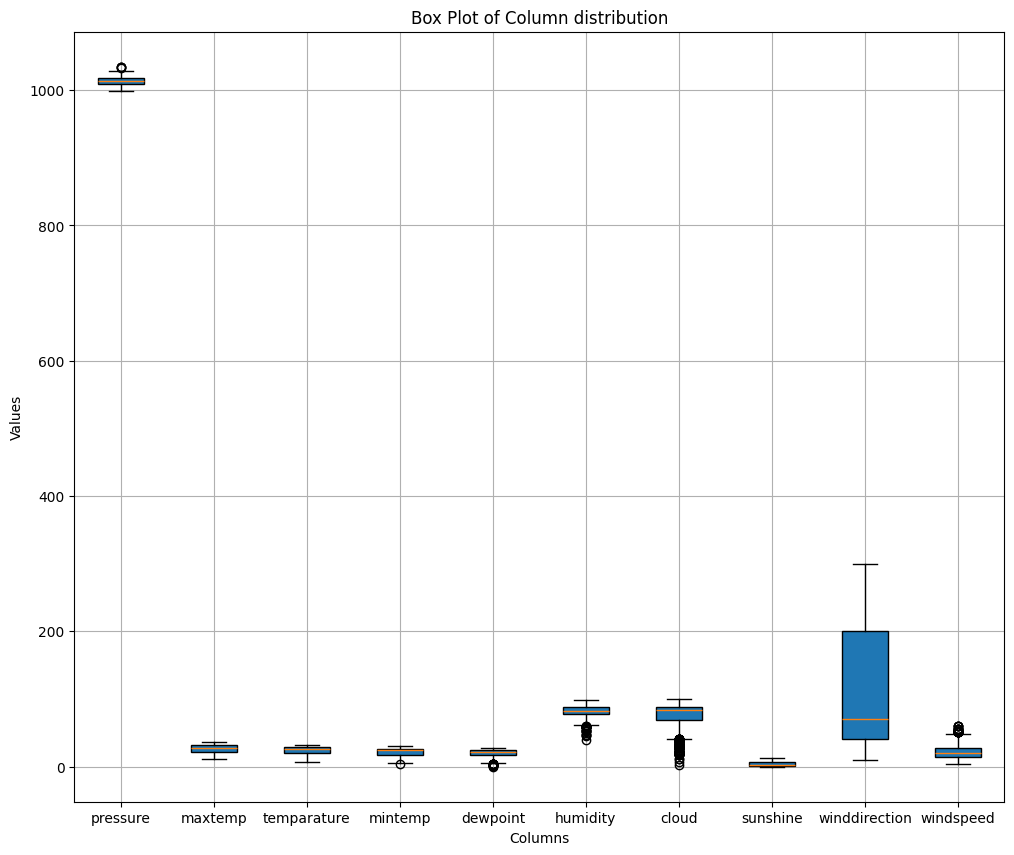

In [5]:
#Boxplot of values

#Making a boxplot df to drop some unplottable columns
BoxPlotDf = TrainDataset
BoxPlotDf = BoxPlotDf.drop(['id','day','rainfall'],axis=1)

plt.figure(figsize=(12, 10))
plt.boxplot(BoxPlotDf.values, labels=BoxPlotDf.columns, patch_artist=True)

plt.xlabel("Columns")
plt.ylabel("Values")
plt.title("Box Plot of Column distribution")
plt.grid(True)
plt.show()

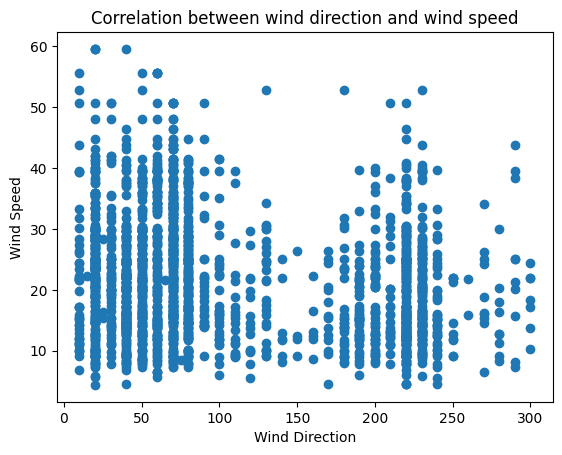

In [6]:
#Scatterplot to show the correlation between cloud and rainfall

x = TrainDataset['winddirection']
y = TrainDataset['windspeed']

plt.scatter(x, y)
plt.xlabel('Wind Direction')
plt.ylabel('Wind Speed')
plt.title('Correlation between wind direction and wind speed')
plt.show()

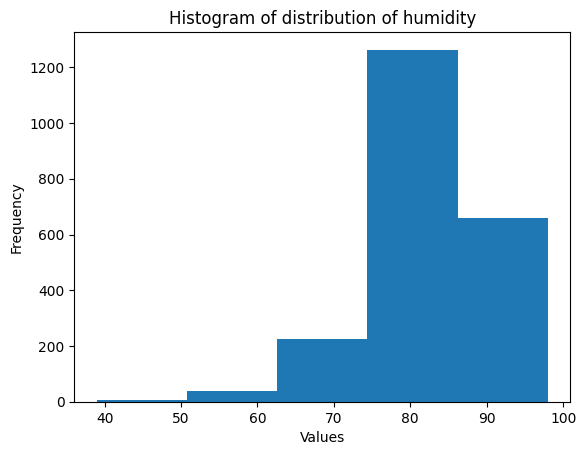

In [7]:
#Histogram of distribution of humidity
Data = TrainDataset['humidity']
plt.hist(Data, bins=5)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of distribution of humidity')
plt.show()

# Machine Learning Model 1 - Logistic Regression:

Validation AUC-ROC Score: 0.8709


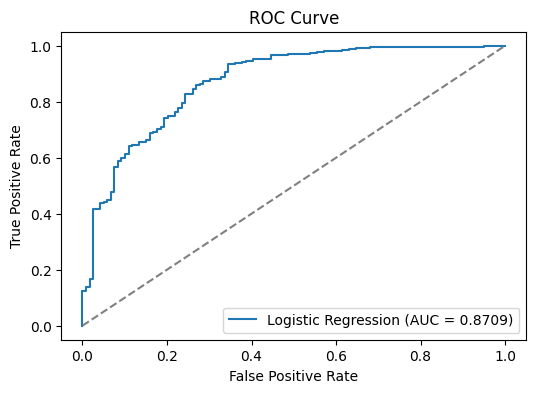

Predictions saved to Predictions.csv


In [20]:
X_train_full = TrainDataset.drop(columns=["rainfall"])  # Features
y_train = TrainDataset["rainfall"]  # Target (binary: 0/1)


X_test = TestDataset.copy()


X_train_full.fillna(X_train_full.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)


z_scores = np.abs(zscore(X_train_full))  # Z-scores for training data
outliers = (z_scores > 4).all(axis=1)  # Consider rows where all features have a Z-score > 3 as outliers

# Filter out outliers
X_train_filtered = X_train_full[~outliers]
y_train_filtered = y_train[~outliers]

# Also filter out outliers in the test dataset if necessary
z_scores_test = np.abs(zscore(X_test))
outliers_test = (z_scores_test > 4).all(axis=1)
X_test_filtered = X_test[~outliers_test]


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_test_scaled = scaler.transform(X_test_filtered)

#Split Training Data for Validation (80% Train, 20% Validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train_filtered, test_size=0.2, random_state=42)

#Train Model
model = LogisticRegression()
model.fit(X_train, y_train)

#Predict
y_val_probs = model.predict_proba(X_val)[:, 1]  # Get probabilities for class 1

#AUC-ROC Score
auc_roc = roc_auc_score(y_val, y_val_probs)
print(f"Validation AUC-ROC Score: {auc_roc:.4f}")

#Plot ROC
fpr, tpr, _ = roc_curve(y_val, y_val_probs)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {auc_roc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random chance line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

#Predict Probabilities on Test Data
y_test_probs = model.predict_proba(X_test_scaled)[:, 1]  # Get probabilities for class 1

# Export to CSV
predictions = pd.DataFrame({"Prediction": y_test_probs})
predictions.to_csv("Predictions.csv", index=False)
print("Predictions saved to Predictions.csv")

# Machine Learning Model 2 - Decision Tree:

Validation AUC-ROC Score: 0.8212


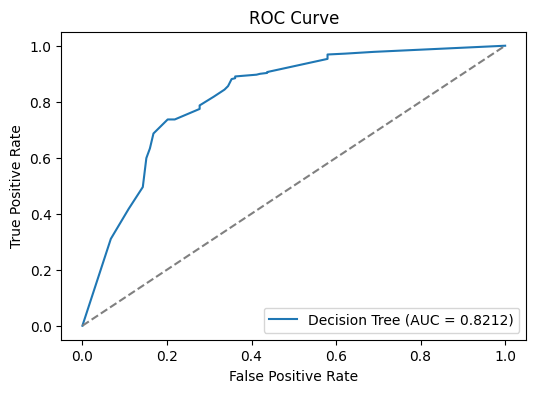

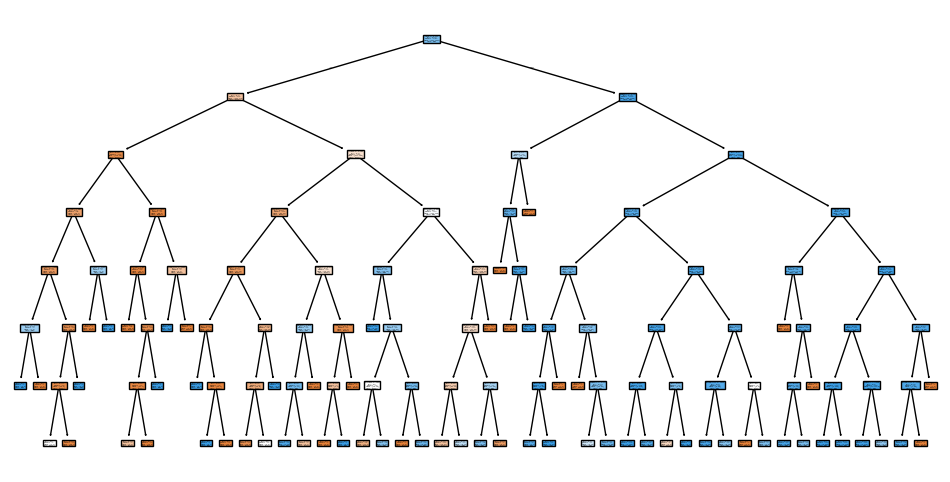

Predictions saved to Predictions.csv


In [21]:

X_train_full = TrainDataset.drop(columns=["rainfall"])  # Features
y_train = TrainDataset["rainfall"]  # Target (binary: 0/1)

X_test = TestDataset.copy()

X_train_full.fillna(X_train_full.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

z_scores = np.abs(zscore(X_train_full))
outliers = (z_scores > 3).all(axis=1)  # Removing rows where all features are outliers
X_train_filtered = X_train_full[~outliers]
y_train_filtered = y_train[~outliers]

#Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_test_scaled = scaler.transform(X_test)

#Split
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train_filtered, test_size=0.2, random_state=42)

#Train Model
model = DecisionTreeClassifier(max_depth=7, random_state=42)  # You can tune max_depth
model.fit(X_train, y_train)

#Predict
y_val_probs = model.predict_proba(X_val)[:, 1]  # Get probabilities for class 1

#Compute AUC-ROC Score
auc_roc = roc_auc_score(y_val, y_val_probs)
print(f"Validation AUC-ROC Score: {auc_roc:.4f}")

#Plot ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_val_probs)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"Decision Tree (AUC = {auc_roc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random chance line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

#Plot Decision Tree
plt.figure(figsize=(12, 6))
plot_tree(model, filled=True, feature_names=TrainDataset.drop(columns=["rainfall"]).columns, class_names=["No Rain", "Rain"])
plt.show()

#Predict
y_test_probs = model.predict_proba(X_test_scaled)[:, 1]  # Get probabilities for class 1

# Export to CSV
predictions = pd.DataFrame({"Prediction": y_test_probs})
predictions.to_csv("Predictions.csv", index=False)
print("Predictions saved to Predictions.csv")

# Machine Learning Model 3 - KNN:

Validation AUC-ROC Score: 0.8336


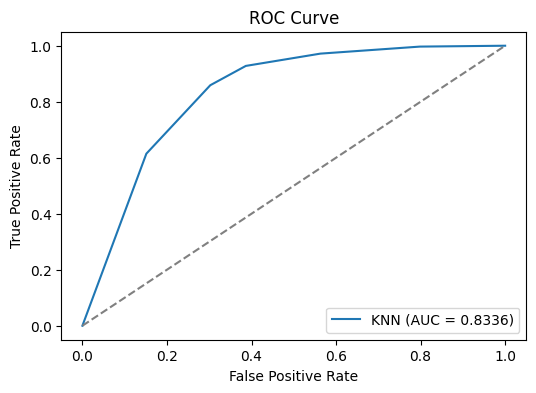

Predictions saved to Predictions.csv


In [22]:


#Separate Features
X_train_full = TrainDataset.drop(columns=["rainfall"])  # Features
y_train = TrainDataset["rainfall"]  # Target (binary: 0/1)

# Ensure test dataset has same features as train dataset
X_test = TestDataset.copy()

# Handle Missing Values
X_train_full.fillna(X_train_full.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

#Outliers
z_scores = np.abs(zscore(X_train_full))
outliers = (z_scores > 3).all(axis=1)  # Removing rows where all features are outliers
X_train_filtered = X_train_full[~outliers]
y_train_filtered = y_train[~outliers]

#Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_test_scaled = scaler.transform(X_test)

#Split Training Data
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train_filtered, test_size=0.2, random_state=42)

#Train
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

#Predict
y_val_probs = model.predict_proba(X_val)[:, 1]  # Get probabilities for class 1

#Compute AUC-ROC Score
auc_roc = roc_auc_score(y_val, y_val_probs)
print(f"Validation AUC-ROC Score: {auc_roc:.4f}")

#Plot
fpr, tpr, _ = roc_curve(y_val, y_val_probs)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"KNN (AUC = {auc_roc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random chance line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

#Predict
y_test_probs = model.predict_proba(X_test_scaled)[:, 1]  # Get probabilities for class 1

# Export to CSV
predictions = pd.DataFrame({"Prediction": y_test_probs})
predictions.to_csv("Predictions.csv", index=False)
print("Predictions saved to Predictions.csv")

# Machine Learning Model 4 - SVM:

Best Hyperparameters: {'gamma': 0.0001, 'C': 1}
SVM AUC-ROC Score: 0.8502
Ensemble AUC-ROC Score: 0.8553


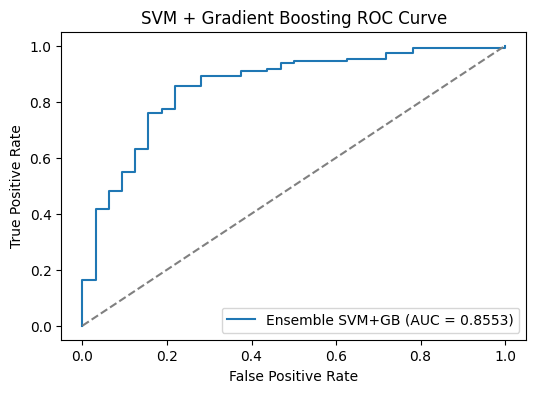

Predictions saved to Optimized_SVM_Predictions.csv


In [64]:
#Separate Features
X_train_full = TrainDataset.drop(columns=["rainfall"])  # Features
y_train = TrainDataset["rainfall"]  # Target (binary: 0/1)

# Ensure test dataset has same features as train dataset
X_test = TestDataset.copy()

#Handle Missing Values
X_train_full.fillna(X_train_full.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

#Remove Outliers
z_scores = np.abs(zscore(X_train_full))
outliers = (z_scores > 3).all(axis=1)  # Removing rows where all features are outliers
X_train_filtered = X_train_full[~outliers]
y_train_filtered = y_train[~outliers]

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_filtered)
X_test_poly = poly.transform(X_test)

#tandardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_test_scaled = scaler.transform(X_test)

#Split Training Data
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train_filtered, test_size=0.2, random_state=42)

#Hyperparameter Tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1]
}

random_search = RandomizedSearchCV(SVC(kernel='rbf', probability=True, random_state=42),
                                   param_distributions=param_grid,
                                   n_iter=5,  # Searches randomly x times
                                   cv=5,
                                   scoring='roc_auc',
                                   random_state=42)

random_search.fit(X_train, y_train)
print("Best Hyperparameters:", random_search.best_params_)

best_model = random_search.best_estimator_

#Train
#best_model = RandomizedSearchCV.best_estimator_  # Get the best model from GridSearchCV
best_model.fit(X_train, y_train)

#Predict
y_val_probs = best_model.predict_proba(X_val)[:, 1]  # Get probabilities for class 1

#Compute AUC-ROC Score
auc_roc = roc_auc_score(y_val, y_val_probs)
print(f"SVM (with GridSearchCV) Validation AUC-ROC Score: {auc_roc:.4f}")

#Plot
fpr, tpr, _ = roc_curve(y_val, y_val_probs)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"SVM (AUC = {auc_roc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random chance line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM ROC Curve")
plt.legend()
plt.show()

#Predict
y_test_probs = best_model.predict_proba(X_test_scaled)[:, 1]  # Get probabilities for class 1

# Export to CSV
predictions = pd.DataFrame({"Prediction": y_test_probs})
predictions.to_csv("SVMPredictionModel.csv", index=False)
print("Predictions saved to SVMPredictionModel.csv")

# Machine Learning Model 5 - Ensemble Method 1:

In [51]:
#Generate Sample Data
X, y = make_classification(n_samples=15000, n_features=10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.487, random_state=42)

#Define Base Models
base_models = [
    ('svm', SVC(probability=True, kernel='rbf', C=5, random_state=42)),
    ('lr', LogisticRegression(C=5, random_state=42)),
    #('dt', DecisionTreeClassifier(max_depth=5, random_state=42)),
    #('gb', GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, random_state=42))
]

#Define Meta-Model
meta_model = LogisticRegression(random_state=42)

#Create Stacking Classifier
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, stack_method='predict_proba')

#Train
stacking_model.fit(X_train, y_train)

#Predict
y_prob = stacking_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (1)

#Compute AUC-ROC Score
auc_score = roc_auc_score(y_test, y_prob)
print(f"Stacking Model AUC-ROC Score: {auc_score:.4f}")

#Export Predictions to CSV
df_predictions = pd.DataFrame({
    'Actual': y_test,
    'Predicted_Probability': y_prob
})

df_predictions.to_csv('predictions_with_probabilities.csv', index=False)
print("✅ Predictions saved to 'predictions_with_probabilities.csv'")

Stacking Model AUC-ROC Score: 0.9608
✅ Predictions saved to 'predictions_with_probabilities.csv'


# Machine Learning Model 6 - Ensemble Method 2:

Best Hyperparameters: {'gamma': 0.0001, 'C': 1}
SVM AUC-ROC Score: 0.8502
Ensemble AUC-ROC Score: 0.8553


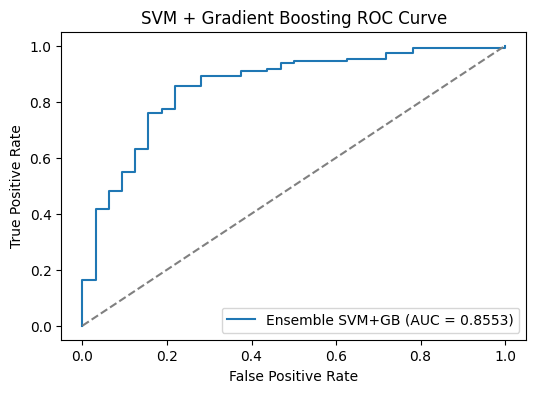

Predictions saved to Optimized_SVM_Predictions.csv


In [79]:
#Load Data
X_train_full = TrainDataset.drop(columns=["rainfall"])
y_train = TrainDataset["rainfall"]
X_test = TestDataset.copy()

#Handle Missing Values
X_train_full.fillna(X_train_full.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

#Remove Outliers (Fix: Remove Any Feature > 5 Std Dev)
z_scores = np.abs(zscore(X_train_full))
outliers = (z_scores > 2).any(axis=1)
X_train_filtered = X_train_full[~outliers]
y_train_filtered = y_train[~outliers]

#Feature Engineering
poly = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_filtered)
X_test_poly = poly.transform(X_test)

#Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

#Train-Validation Split
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train_filtered, test_size=0.1, random_state=42)

#Hyperparameter Tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1]
}

random_search = RandomizedSearchCV(SVC(kernel='rbf', probability=True, random_state=42),
                                   param_distributions=param_grid,
                                   n_iter=2,
                                   cv=2,
                                   scoring='roc_auc',
                                   random_state=42)

random_search.fit(X_train, y_train)

#Best Model
best_model = random_search.best_estimator_
print("Best Hyperparameters:", random_search.best_params_)

#Train Final Model
best_model.fit(X_train, y_train)

#Evaluate Model
y_val_probs = best_model.predict_proba(X_val)[:, 1]
auc_roc = roc_auc_score(y_val, y_val_probs)
print(f"SVM AUC-ROC Score: {auc_roc:.4f}")

#Ensemble with Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

ensemble_model = VotingClassifier(estimators=[
    ('svm', best_model),
    ('gb', gb)],
    voting='soft')

ensemble_model.fit(X_train, y_train)

#Evaluate Ensemble Model
y_val_probs_ensemble = ensemble_model.predict_proba(X_val)[:, 1]
ensemble_auc = roc_auc_score(y_val, y_val_probs_ensemble)
print(f"Ensemble AUC-ROC Score: {ensemble_auc:.4f}")

#ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_val_probs_ensemble)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"Ensemble SVM+GB (AUC = {ensemble_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM + Gradient Boosting ROC Curve")
plt.legend()
plt.show()

#Predict & Export to CSV
y_test_probs = ensemble_model.predict_proba(X_test_scaled)[:, 1]
predictions = pd.DataFrame({"Prediction": y_test_probs})
predictions.to_csv("Optimized_SVM_Predictions.csv", index=False)
print("Predictions saved to Optimized_SVM_Predictions.csv")